In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import warnings

warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
pools = ['Pool_49', 'Pool_52', 'Pool_60']
algorithms = ['DeepNovo']
alg_file = ['deepnovo']

RESULT_DIR = '../../../Data/Analysis_new/'

In [3]:
experiment_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        raw_data =pd.read_csv(
            f"../../../Data/Datasets/{p}/Thermo_SRM_{p}_01_01_3xHCD-1h-R2-tryptic/msmsScans.txt",
            sep='\t', index_col=None)
        pool_dict[alg] = raw_data [['Scan number', 'Identified', 'Sequence', 'Filtered peaks']]
    experiment_data_dict[p] = pool_dict

In [12]:
pepmass_data_dict = {}

for p in pools:
    raw_data =pd.read_csv(
        f"../../../Data/Datasets/{p}/mgf_pepmass_distribution.tsv",
        sep='\t', index_col=None)
    pepmass_data_dict[p] = raw_data

In [17]:
precursor_data_dict = {}

for p in pools:
    raw_data =pd.read_csv(
        f"../../../Data/Datasets/{p}/mgf_precursormass_distribution.tsv",
        sep='\t', index_col=None)
    precursor_data_dict[p] = raw_data

In [5]:
parsed_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        parsed_data = pd.read_csv(f'../../../Data/ParsingResults/{p}/{file}_results_all_sequences.tsv', sep='\t', index_col=None)
        pool_dict[alg] = parsed_data
    parsed_data_dict[p] = pool_dict

In [6]:
scored_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        file = file+'_scored'
        #if file == 'direcTag_scored':
         #   file = file + '_grouped'

        identified_maxquant = pd.read_csv(f'../../../Data/ScoringResults/{p}/{file}.tsv', sep='\t', index_col=None, header=0)
        identified_maxquant['by'] = 'MaxQuant'
        identified_inclusion_list= pd.read_csv(f'../../../Data/ScoringResults_Unidentified/CheckInclusionList/{p}/{file}.tsv', sep='\t', index_col=None, header=0)
        identified_inclusion_list['by'] = 'InclusionList'
        pool_dict[alg] = pd.concat([identified_maxquant, identified_inclusion_list], axis=0)
    scored_data_dict[p] = pool_dict

In [7]:
peak_distribution_dict = {}
for p in pools:
    peaks_dist =pd.read_csv(
        f"../../../Data/Datasets/{p}/mgf_peaks_distribution.tsv",
        sep='\t', index_col=None)
    peak_distribution_dict[p] = peaks_dist

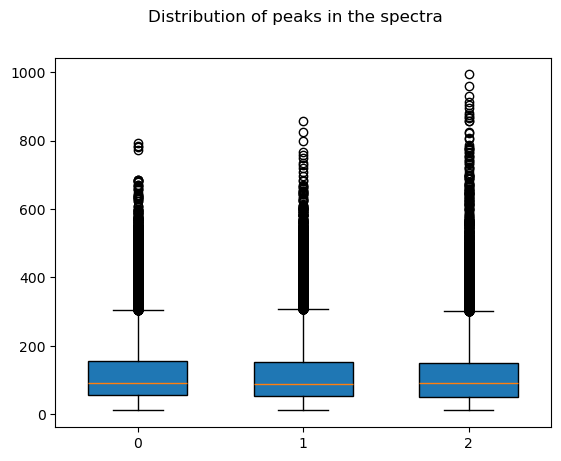

In [8]:
fig, ax = plt.subplots()
for i, p in enumerate(pools):
    raw_df = peak_distribution_dict[p].copy()
    ax.boxplot(raw_df['PeakCount'], positions=[i], widths=0.6, patch_artist=True)
fig.suptitle('Distribution of peaks in the spectra')
plt.show()

726.4253790039061 3043.541309765624
243
743.3908941406261 2994.504126855468
0
783.4942876953121 2758.36966640625
0


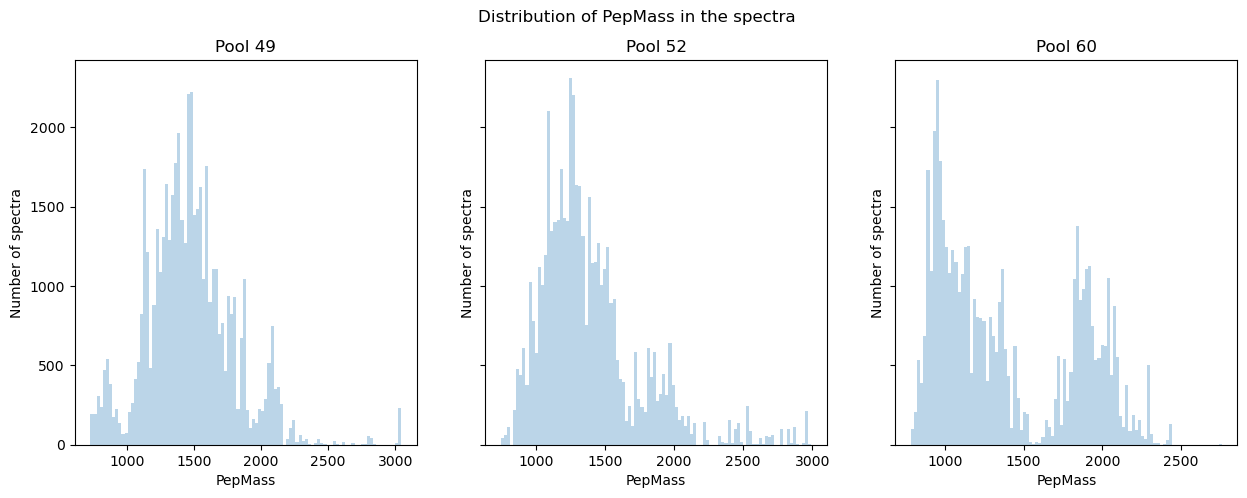

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
for i, p in enumerate(pools):
    raw_df = pepmass_data_dict[p].copy()
    raw_df['']
    print(raw_df['PepMass'].min(), raw_df['PepMass'].max())
    print(raw_df.query('PepMass > 3000').shape[0])
    ax[i].hist(raw_df['PepMass'], bins=100, alpha=0.3)
    ax[i].set_title(f"{' '.join(p.split('_'))}")
    ax[i].set_xlabel("PepMass")
    ax[i].set_ylabel("Number of spectra")

fig.suptitle('Distribution of PepMass in the spectra')
plt.show()

361.8493 1215.56726074219
1452
361.536010742188 1268.15991210938
750
359.1815 1215.1606
2724


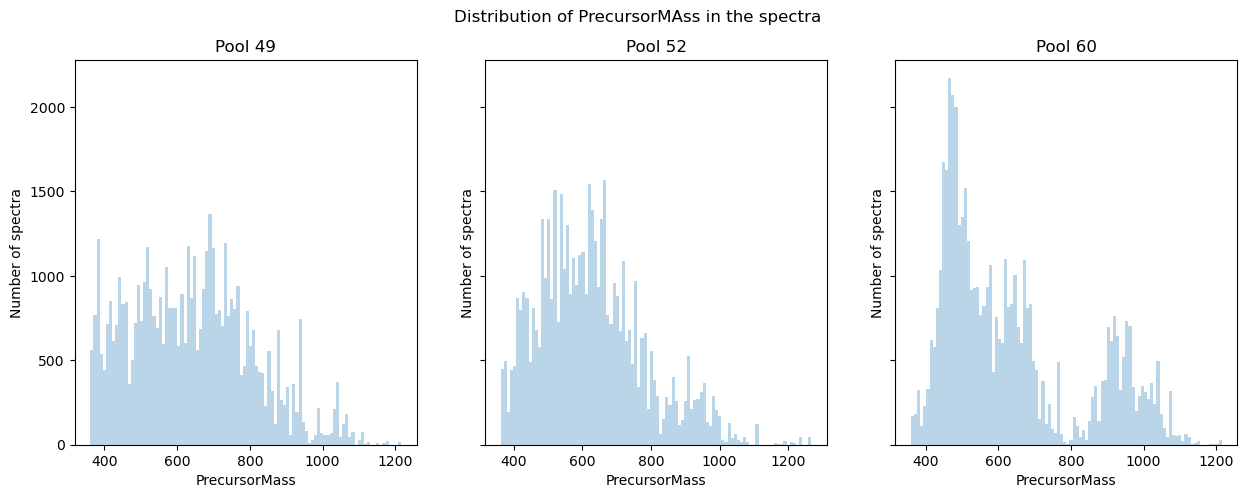

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
for i, p in enumerate(pools):
    raw_df = precursor_data_dict[p]
    print(raw_df['PrecursorMass'].min(), raw_df['PrecursorMass'].max())
    print(raw_df.query('PrecursorMass > 1000').shape[0])
    ax[i].hist(raw_df['PrecursorMass'], bins=100, alpha=0.3)
    ax[i].set_title(f"{' '.join(p.split('_'))}")
    ax[i].set_xlabel("PrecursorMass")
    ax[i].set_ylabel("Number of spectra")

fig.suptitle('Distribution of PrecursorMAss in the spectra')
plt.show()

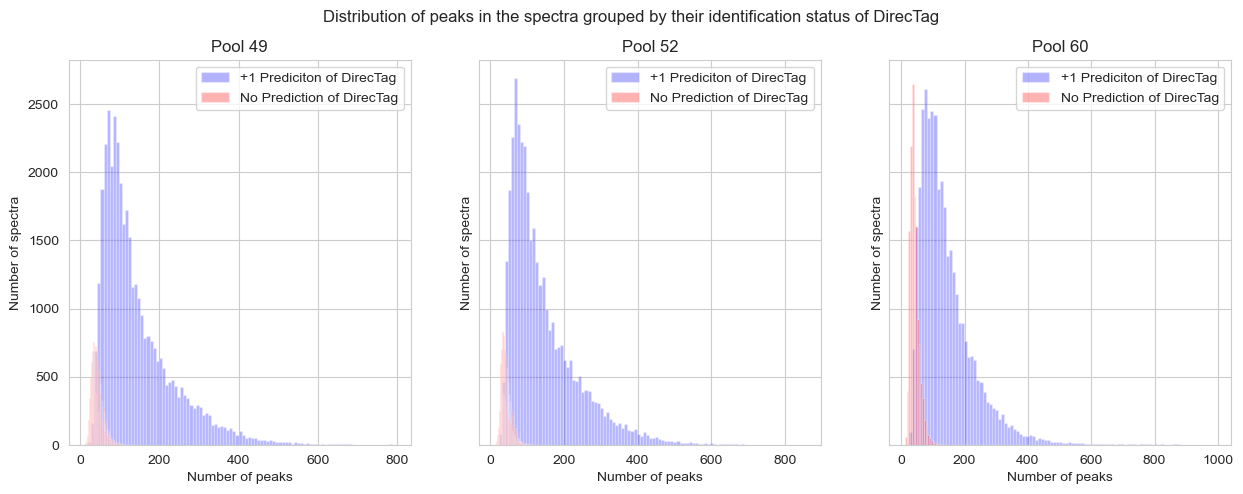

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
for i, p in enumerate(pools):
    raw_df = peak_distribution_dict[p].copy()
    parsed_df = parsed_data_dict[p]['DirecTag'].copy()
    merged_df = pd.merge(raw_df, parsed_df, left_index=True, right_on='ID', how='left')

    merged_df = merged_df.drop_duplicates(subset='ID')

    merged_df = merged_df[['Scan_x', 'PeakCount', 'ID', 'Predicted']]

    nan_count = merged_df['Predicted'].isna().sum()

    identified_df = merged_df[merged_df['Predicted'].notna()]
    not_identified_df = merged_df[merged_df['Predicted'].isna()]

    ax[i].hist(identified_df['PeakCount'], bins=100, alpha=0.3, color='b', label='+1 Prediciton of DirecTag')
    ax[i].hist(not_identified_df['PeakCount'], bins=100, alpha=0.3, color='r', label='No Prediction of DirecTag')
    ax[i].legend()
    ax[i].set_title(f"{' '.join(p.split('_'))}")
    ax[i].set_xlabel("Number of peaks")
    ax[i].set_ylabel("Number of spectra")

fig.suptitle('Distribution of peaks in the spectra grouped by their identification status of DirecTag')
plt.show()
fig.savefig(f'{RESULT_DIR}/DirecTag/peak_distribution_direcTag.png')